# KMeans for player clustering

In this notebook, we will train an unsupervised machine learning algorithm called KMeans.

KMeans is capable of discovering patterns in data and creating groups of data points.

In this notebook, we will use a dataset I scraped from FBREF on my own.

This dataset contains players stats of the Argentinian league. We want to cluster __midfielders__ that share similar characteristics. For example, more defensive, more offensive, playmaker, box-to-box, etc.

First we import the necessary packages.

In [693]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Let's start by reading the dataset using pandas.


In [694]:
players_df = pd.read_csv('FBRef_2024_CopaDeLaLiga.csv')

## Data preprocessing and cleanup

First, we examine what data we have at our disposal.
We use .head() function to see the data itself.
We will use .info() to see all columns, column types and any NaN values

In [695]:
players_df.head()

,Unnamed: 0,Rk,Player,Nation,Pos,Squad,Age,Born,Matches Played,Starts,...,Interceptions,Passes Blocked,Shots Blocked,Tackles,Tackles Att 3rd,Tackles Def 3rd,Tackles Mid 3rd,Tackles Won,Tackles+Interceptions,Total Blocks
0,0,1,Matías Abaldo,uy URU,"MF,FW",Gimnasia ELP,20-025,2004,7,5,...,2,4,0,4,1,3,0,2,6,4
1,1,2,Luciano Abecasis,ar ARG,"MF,DF",Independiente Rivadavia,33-329,1990,12,10,...,2,10,1,19,0,4,15,11,21,11
2,2,3,Ramón Ábila,ar ARG,FW,Barracas Central,34-197,1989,9,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,Jonás Acevedo,ar ARG,"MF,FW",Instituto,27-082,1997,9,6,...,3,6,1,13,4,5,4,7,16,7
4,4,5,Guillermo Acosta,ar ARG,MF,Tucumán,35-180,1988,10,10,...,12,3,1,17,0,5,12,9,29,4


In [696]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 88 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    797 non-null    int64 
 1   Rk                            797 non-null    object
 2   Player                        797 non-null    object
 3   Nation                        788 non-null    object
 4   Pos                           796 non-null    object
 5   Squad                         797 non-null    object
 6   Age                           788 non-null    object
 7   Born                          788 non-null    object
 8   Matches Played                797 non-null    object
 9   Starts                        797 non-null    object
 10  Min                           797 non-null    object
 11  90s                           797 non-null    object
 12  Gls                           797 non-null    object
 13  Ast                 

First, we want to reduce our sample to players whose main position is midfielder ("MF"). There are midfielders that can also play as DF or FW.

In [697]:
# Filter by position
players_df = players_df[
    (players_df["Pos"] == "MF") |
    (players_df["Pos"] == "MF,FW") |
    (players_df["Pos"] == "MF,DF")
]


Which are the metrics that are going to help our algorithm cluster the different type of midfielders?
We exclude metrics that are not significant and will hinder our algorithm.
We exclude 90' metrics since we are going to calculate them later.
We also excluded accuracy metrics, for example, the number of correct passes will not help us deduce the characteristics and behaviour of midfielders.

In [698]:
metrics = ['Player', "Min", 'Gls', 'Ast', 'xG', 'xAG',
       'Progressive Carries', 'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attempted', 'Total Passing Distance', 'xA', 'Through Balls', 'Clearances',
       'Interceptions', 'Tackles', 'Total Blocks']

players_df = players_df[metrics]
players_df.columns

Index(['Player', 'Min', 'Gls', 'Ast', 'xG', 'xAG', 'Progressive Carries',
       'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attempted',
       'Total Passing Distance', 'xA', 'Through Balls', 'Clearances',
       'Interceptions', 'Tackles', 'Total Blocks'],
      dtype='object')

Convert all columns to numeric, excluding the "Player" column which is the first index

In [699]:
# Convert all columns except the first one to numeric values explicitly
# for col in players_df.columns[1:]:
#     players_df[col] = pd.to_numeric(players_df[col], errors='coerce'


players_df.iloc[:, 1:] = players_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')


# Check the data types
players_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 0 to 796
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Player                        277 non-null    object
 1   Min                           277 non-null    object
 2   Gls                           277 non-null    object
 3   Ast                           277 non-null    object
 4   xG                            256 non-null    object
 5   xAG                           256 non-null    object
 6   Progressive Carries           256 non-null    object
 7   Progressive Passes            256 non-null    object
 8   Crosses into Penalty Area     256 non-null    object
 9   Key Passes                    256 non-null    object
 10  Long Passes Attempted         256 non-null    object
 11  Medium Passes Attempted       256 non-null    object
 12  Passes into Final Third       256 non-null    object
 13  Passes into Penalty Area 

Players that did not play sufficient amount of minutes will have data that may not be accurate to the player. We exclude players with less than 500 minutes played that season.

In [700]:
# Filter the DataFrame for rows where 'Min' > 500
players_df = players_df[players_df['Min'] > 500]
players_df.reset_index(inplace=True, drop=True)

players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Player                        112 non-null    object
 1   Min                           112 non-null    object
 2   Gls                           112 non-null    object
 3   Ast                           112 non-null    object
 4   xG                            104 non-null    object
 5   xAG                           104 non-null    object
 6   Progressive Carries           104 non-null    object
 7   Progressive Passes            104 non-null    object
 8   Crosses into Penalty Area     104 non-null    object
 9   Key Passes                    104 non-null    object
 10  Long Passes Attempted         104 non-null    object
 11  Medium Passes Attempted       104 non-null    object
 12  Passes into Final Third       104 non-null    object
 13  Passes into Penalty 

There are columns that do not contain any data, we can see that the Gls and Ast columns have more Non-null values, we want to delete rows most columns are NaN.
We can use the dropna function, which will drop rows with a specific threshold. The threshold will set how many non-NA values we want.

In [701]:
# Define the threshold: keep rows with at least 60% of columns containing non-NaN values
threshold = int(0.7 * len(players_df.columns))

# Drop rows that do not meet the threshold
players_df = players_df.dropna(thresh=threshold)

players_df.reset_index(inplace=True, drop=True)

players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Player                        104 non-null    object
 1   Min                           104 non-null    object
 2   Gls                           104 non-null    object
 3   Ast                           104 non-null    object
 4   xG                            104 non-null    object
 5   xAG                           104 non-null    object
 6   Progressive Carries           104 non-null    object
 7   Progressive Passes            104 non-null    object
 8   Crosses into Penalty Area     104 non-null    object
 9   Key Passes                    104 non-null    object
 10  Long Passes Attempted         104 non-null    object
 11  Medium Passes Attempted       104 non-null    object
 12  Passes into Final Third       104 non-null    object
 13  Passes into Penalty 

We want to convert all the metrics to per 90' scale, first we copy the dataframe into another variable

In [702]:
players_90 = players_df.copy(deep=True)

Create a new column for the matches played, which is the player's total minutes divided by 90

In [703]:
players_90["Min_per_90"] = players_90["Min"] / 90

players_90[["Player", "Min", "Min_per_90"]].head()

,Player,Min,Min_per_90
0,Luciano Abecasis,860,9.555556
1,Jonás Acevedo,555,6.166667
2,Guillermo Acosta,782,8.688889
3,Gabriel Alanís,546,6.066667
4,William Alarcón,1101,12.233333


In [704]:
# Perform the division for columns starting from the third column
players_90.iloc[:, 2:] = players_90.iloc[:, 2:].div(players_90["Min_per_90"], axis=0)

players_90.head()

,Player,Min,Gls,Ast,xG,xAG,Progressive Carries,Progressive Passes,Crosses into Penalty Area,Key Passes,...,Progressive Passing Distance,Short Passes Attempted,Total Passing Distance,xA,Through Balls,Clearances,Interceptions,Tackles,Total Blocks,Min_per_90
0,Luciano Abecasis,860,0.104651,0.104651,0.010465,0.136047,1.255814,4.5,0.837209,1.674419,...,175.290698,16.953488,543.244186,0.167442,0.0,1.046512,0.209302,1.988372,1.151163,1.0
1,Jonás Acevedo,555,0.0,0.324324,0.145946,0.324324,2.756757,4.378378,0.324324,2.27027,...,144.486486,15.72973,446.918919,0.340541,0.162162,0.162162,0.486486,2.108108,1.135135,1.0
2,Guillermo Acosta,782,0.11509,0.0,0.046036,0.069054,1.381074,6.329923,0.11509,1.035806,...,237.774936,15.421995,643.120205,0.069054,0.11509,1.726343,1.381074,1.956522,0.460358,1.0
3,Gabriel Alanís,546,0.164835,0.164835,0.197802,0.032967,2.802198,1.648352,0.164835,0.659341,...,46.978022,10.21978,244.945055,0.016484,0.164835,0.824176,0.164835,2.307692,0.824176,1.0
4,William Alarcón,1101,0.163488,0.245232,0.040872,0.147139,1.389646,8.174387,0.163488,0.899183,...,255.367847,19.700272,692.942779,0.138965,0.326975,1.144414,0.735695,1.226158,0.245232,1.0


Now we drop the minutes columns

In [705]:
players_90.drop(columns=["Min_per_90", "Min"], inplace=True)

## Feature Engineering

We want to reduce the scale of each feature by normalizing the data

In [706]:
minmax_scaler = MinMaxScaler()

# Exclude the player column
norm_X = players_df.iloc[:, 1:]

# Perform the normalization
norm_X = minmax_scaler.fit_transform(norm_X.to_numpy())

For KMeans algorithm, we want to reduce the numbers of components for an easier cluster using Principal Component Analysis (PCA)

In [707]:
pca = PCA(n_components=2)

reduced = pca.fit_transform(norm_X)
reduced = pd.DataFrame(reduced)

reduced.head()


,0,1
0,0.154462,-0.301112
1,-0.461287,-0.580656
2,-0.131928,0.158413
3,-0.997610,-0.438342
4,0.884441,0.070743


What would be a good number of clusters?
There are different types of midfielders, for example we can have more offensive midfielders, playmakers, box to box, defensive midfielders, etc.

The elbow method will help find us find the number of clusters that would be optmal for our data.
WCSS variable will contain the wcss for each cluster, which is the distance between points within each cluster, the lower the more compact clusters are.

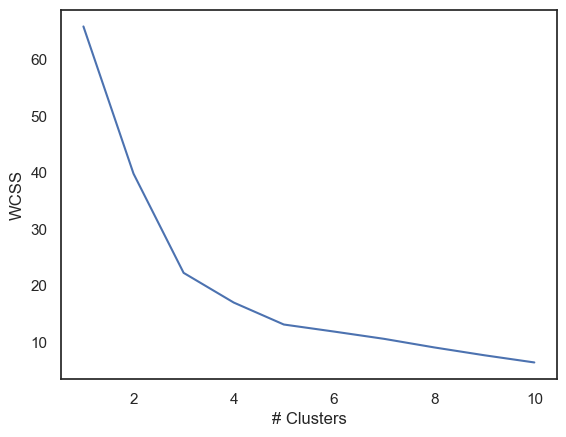

In [708]:
wcss = []

for i in range(1,11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
        kmeans.fit(reduced)
        wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.xlabel("# Clusters")
plt.ylabel("WCSS")
plt.show()


Now that we found an optimal number of clusters, we train the model.

In [709]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(reduced)

labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

We need to combine player names with the new data predicted from the KMeans algorithm.
We create a table that will contain the x y coordinates of each player, the group it was assigned, and the player name.

In [710]:
players = players_90["Player"]

reduced['cluster'] = clusters
reduced['Player'] = players
reduced.columns = ['x', 'y', 'cluster', 'Player']
reduced

,x,y,cluster,Player
0,0.154462,-0.301112,3,Luciano Abecasis
1,-0.461287,-0.580656,3,Jonás Acevedo
2,-0.131928,0.158413,2,Guillermo Acosta
3,-0.997610,-0.438342,3,Gabriel Alanís
4,0.884441,0.070743,1,William Alarcón
...,...,...,...,...
99,-0.442879,-0.290450,3,Renzo Tesuri
100,-0.668669,0.098804,2,Rodrigo Villagra
101,-0.544911,0.369573,2,Carlos Villalba
102,1.673887,-1.252324,1,Kevin Zenon


We plot our findings and analyze the clusters

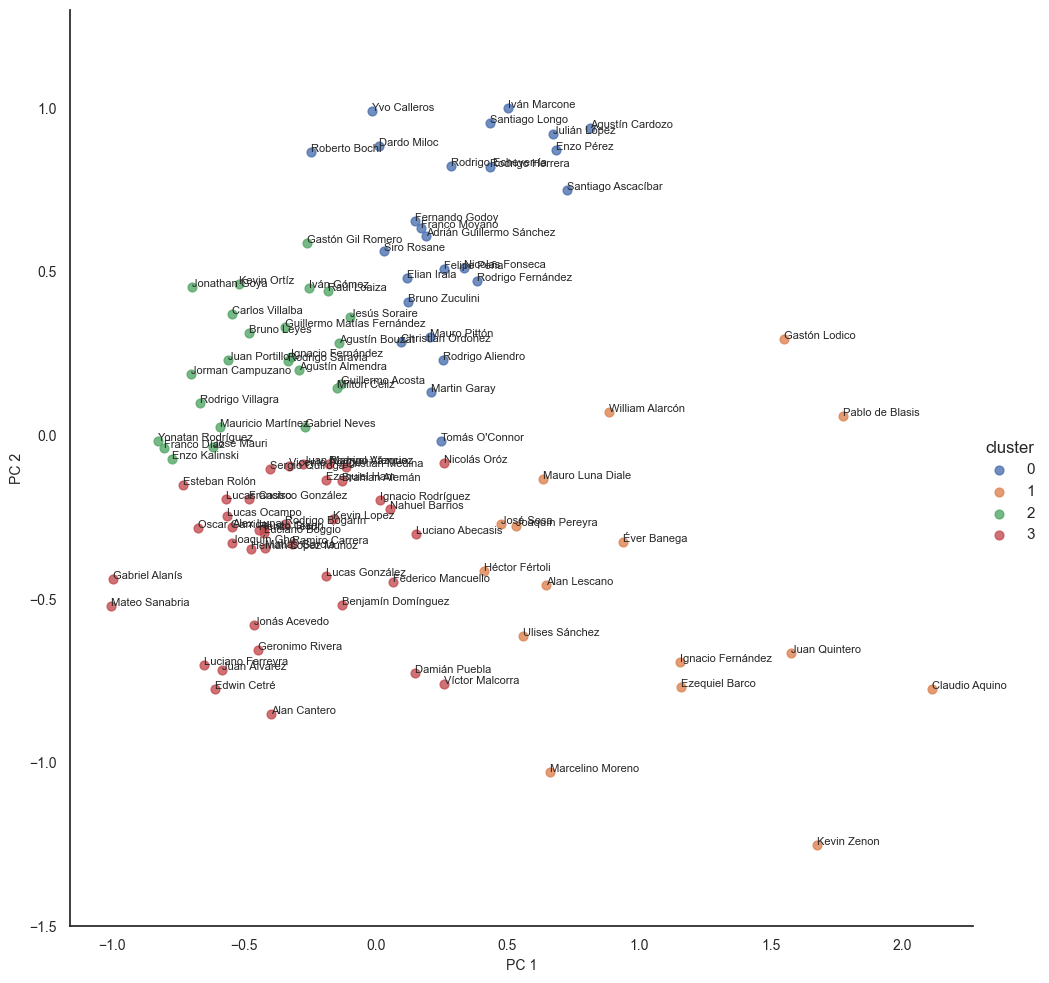

In [711]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot
ax = sns.lmplot(x="x", y="y", hue='cluster', data=reduced, legend=True,
                fit_reg=False, height=10, scatter_kws={"s": 40})

# Add text annotations with smaller font size
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.Player):
    texts.append(plt.text(x, y, s, fontsize=8))  # Adjust fontsize as needed

# Set the limits and labels
ax.set(ylim=(-1.5, 1.3))
plt.tick_params(labelsize=10)
plt.xlabel("PC 1", fontsize=10)
plt.ylabel("PC 2", fontsize=10)

plt.show()


For this example, I chose a number of 4 clusters. One for defensive midfielders, one for box-to-box, and two for more offensive midfielders.



Cluster 0 would be the more defensive midfielders. Enzo Perez from Estudiantes, Ivan Marcone from Independiente are examples.
Cluster 1 are the more offensive midfielders and playmakers. Ezequiel Barco and Ignacio Fernandez from River Plate, Juanfer Quintero from Racing, and Kevin Zenon from Boca Juniors are clear examples.
Cluster 2 are defensive midfielders with good passing, just like Equi Fernandez from Boca and Rodrigo Villagra from River Plate, this could also be considered box-to-box midfielders.
Cluster 3 are also offensive midfielders but with different characteristics than from the ones in Cluster 1. 